In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
np.random.seed(10)   
tf.random.set_seed(10)

In [ ]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1] 
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data/p5270MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(),'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
         freqQAmpI_filt       C_filt
0         31453.223522  5490.232850
1         31438.277060  5490.239343
2         31421.341616  5490.240838
3         31409.798761  5490.232728
4         31398.815589  5490.222463
...                ...          ...
132394    31055.686766  5457.051859
132395    31041.955345  5457.082380
132396    31035.059531  5457.111463
132397    31020.001291  5457.126443
132398    31012.016780  5457.151945

[132399 rows x 2 columns]
Target Data:
               SS    V_filt
0       5.656166  1.201004
1       5.657157  1.243144
2       5.658317  1.264215
3       5.659499  1.243144
4       5.660404  1.222074
...          ...       ...
132394  5.471059  1.285285
132395  5.474545  0.948161
132396  5.478286  1.158863
132397  5.481751  1.201004
132398  5.484813  0.526756

[132399 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape 
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (132099, 300, 2)
Target shape (SS), Y =  (132099,)
Target shape (V), Y =  (132099,)
After reshaping, X =  (132099, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Train
X_train = X_train[13210:92469] 
Y_train_SS = Y_train_SS[13210:92469]
Y_train_V = Y_train_V[13210:92469]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 79259
Validation samples: 13210
Testing samples: 26420


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [ ]:
# Define DD
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [ ]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 79259 samples, validate on 13210 samples
Epoch 1/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0285 - dense_5_loss: 0.0185 - dense_6_loss: 0.0100 - dense_5_mse: 0.0185 - dense_6_mse: 0.0100

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 0.01764, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 10s 130us/sample - loss: 0.0285 - dense_5_loss: 0.0185 - dense_6_loss: 0.0100 - dense_5_mse: 0.0185 - dense_6_mse: 0.0100 - val_loss: 0.0176 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0147 - val_dense_5_mse: 0.0030 - val_dense_6_mse: 0.0146
Epoch 2/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0122 - dense_5_loss: 0.0032 - dense_6_loss: 0.0090 - dense_5_mse: 0.0032 - dense_6_mse: 0.0090
Epoch 2: val_loss improved from 0.01764 to 0.01427, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 111us/sample - loss: 0.0122 - dense_5_loss: 0.0032 - dense_6_loss: 0.0091 - dense_5_mse: 0.0032 - dense_6_mse: 0.0091 - val_loss: 0.0143 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 0.0107 - val_dense_5_mse: 0.0036 - val_dense_6_mse: 0.0107
Epoch 3/100
78880/79259 [============================>.] - ETA: 0s - loss: 0.0092 - dense_5_loss: 0.0032 - dense_6_loss: 0.0060 - dense_5_mse: 0.0032 - dense_6_mse: 0.0060
Epoch 3: val_loss did not improve from 0.01427
79259/79259 [==============================] - 7s 94us/sample - loss: 0.0092 - dense_5_loss: 0.0032 - dense_6_loss: 0.0060 - dense_5_mse: 0.0032 - dense_6_mse: 0.0060 - val_loss: 0.0165 - val_dense_5_loss: 0.0040 - val_dense_6_loss: 0.0125 - val_dense_5_mse: 0.0040 - val_dense_6_mse: 0.0125
Epoch 4/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0091 - dense_5_loss: 0.0031 - dense_6_loss: 0.0060 - dense_5_mse: 0.0031 - dense_6_mse: 0.0060
Epoch 4: val_loss improv

79259/79259 [==============================] - 9s 110us/sample - loss: 0.0091 - dense_5_loss: 0.0031 - dense_6_loss: 0.0060 - dense_5_mse: 0.0031 - dense_6_mse: 0.0060 - val_loss: 0.0101 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 0.0072 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 0.0072
Epoch 5/100
78880/79259 [============================>.] - ETA: 0s - loss: 0.0070 - dense_5_loss: 0.0027 - dense_6_loss: 0.0043 - dense_5_mse: 0.0027 - dense_6_mse: 0.0043
Epoch 5: val_loss improved from 0.01005 to 0.00449, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 112us/sample - loss: 0.0070 - dense_5_loss: 0.0027 - dense_6_loss: 0.0043 - dense_5_mse: 0.0027 - dense_6_mse: 0.0043 - val_loss: 0.0045 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0028 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0028
Epoch 6/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0063 - dense_5_loss: 0.0026 - dense_6_loss: 0.0038 - dense_5_mse: 0.0026 - dense_6_mse: 0.0038
Epoch 6: val_loss improved from 0.00449 to 0.00429, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 114us/sample - loss: 0.0063 - dense_5_loss: 0.0026 - dense_6_loss: 0.0038 - dense_5_mse: 0.0026 - dense_6_mse: 0.0038 - val_loss: 0.0043 - val_dense_5_loss: 0.0016 - val_dense_6_loss: 0.0027 - val_dense_5_mse: 0.0016 - val_dense_6_mse: 0.0027
Epoch 7/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0056 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033
Epoch 7: val_loss did not improve from 0.00429
79259/79259 [==============================] - 9s 112us/sample - loss: 0.0056 - dense_5_loss: 0.0023 - dense_6_loss: 0.0033 - dense_5_mse: 0.0023 - dense_6_mse: 0.0033 - val_loss: 0.0051 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0036 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0036
Epoch 8/100
79008/79259 [============================>.] - ETA: 0s - loss: 0.0071 - dense_5_loss: 0.0026 - dense_6_loss: 0.0045 - dense_5_mse: 0.0026 - dense_6_mse: 0.0045
Epoch 8: val_loss did n

79259/79259 [==============================] - 9s 115us/sample - loss: 0.0050 - dense_5_loss: 0.0021 - dense_6_loss: 0.0029 - dense_5_mse: 0.0021 - dense_6_mse: 0.0029 - val_loss: 0.0030 - val_dense_5_loss: 0.0015 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0015 - val_dense_6_mse: 0.0015
Epoch 12/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0049 - dense_5_loss: 0.0019 - dense_6_loss: 0.0029 - dense_5_mse: 0.0019 - dense_6_mse: 0.0029
Epoch 12: val_loss did not improve from 0.00296
79259/79259 [==============================] - 9s 118us/sample - loss: 0.0049 - dense_5_loss: 0.0019 - dense_6_loss: 0.0029 - dense_5_mse: 0.0019 - dense_6_mse: 0.0029 - val_loss: 0.0037 - val_dense_5_loss: 0.0017 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0017 - val_dense_6_mse: 0.0020
Epoch 13/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0044 - dense_5_loss: 0.0018 - dense_6_loss: 0.0026 - dense_5_mse: 0.0018 - dense_6_mse: 0.0026
Epoch 13: val_loss d

79259/79259 [==============================] - 9s 115us/sample - loss: 0.0037 - dense_5_loss: 0.0015 - dense_6_loss: 0.0022 - dense_5_mse: 0.0015 - dense_6_mse: 0.0022 - val_loss: 0.0026 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0013
Epoch 20/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0014 - dense_6_loss: 0.0021 - dense_5_mse: 0.0014 - dense_6_mse: 0.0021
Epoch 20: val_loss improved from 0.00259 to 0.00239, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 9s 111us/sample - loss: 0.0035 - dense_5_loss: 0.0014 - dense_6_loss: 0.0021 - dense_5_mse: 0.0014 - dense_6_mse: 0.0021 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0013
Epoch 21/100
79168/79259 [============================>.] - ETA: 0s - loss: 0.0034 - dense_5_loss: 0.0014 - dense_6_loss: 0.0020 - dense_5_mse: 0.0014 - dense_6_mse: 0.0020
Epoch 21: val_loss did not improve from 0.00239
79259/79259 [==============================] - 8s 95us/sample - loss: 0.0034 - dense_5_loss: 0.0014 - dense_6_loss: 0.0020 - dense_5_mse: 0.0014 - dense_6_mse: 0.0020 - val_loss: 0.0063 - val_dense_5_loss: 0.0018 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0018 - val_dense_6_mse: 0.0045
Epoch 22/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0040 - dense_5_loss: 0.0016 - dense_6_loss: 0.0023 - dense_5_mse: 0.0016 - dense_6_mse: 0.0023
Epoch 22: val_loss di

79259/79259 [==============================] - 9s 118us/sample - loss: 0.0031 - dense_5_loss: 0.0012 - dense_6_loss: 0.0019 - dense_5_mse: 0.0012 - dense_6_mse: 0.0019 - val_loss: 0.0022 - val_dense_5_loss: 9.6741e-04 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 9.6749e-04 - val_dense_6_mse: 0.0012
Epoch 32/100
79104/79259 [============================>.] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019
Epoch 32: val_loss did not improve from 0.00218
79259/79259 [==============================] - 8s 95us/sample - loss: 0.0033 - dense_5_loss: 0.0014 - dense_6_loss: 0.0019 - dense_5_mse: 0.0014 - dense_6_mse: 0.0019 - val_loss: 0.0048 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0014
Epoch 33/100
79008/79259 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0013 - dense_6_loss: 0.0019 - dense_5_mse: 0.0013 - dense_6_mse: 0.0019
Epoch 33: val

79259/79259 [==============================] - 9s 115us/sample - loss: 0.0026 - dense_5_loss: 0.0011 - dense_6_loss: 0.0015 - dense_5_mse: 0.0011 - dense_6_mse: 0.0015 - val_loss: 0.0022 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0011
Epoch 38/100
78784/79259 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 38: val_loss did not improve from 0.00217
79259/79259 [==============================] - 7s 93us/sample - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016 - val_loss: 0.0028 - val_dense_5_loss: 0.0012 - val_dense_6_loss: 0.0015 - val_dense_5_mse: 0.0012 - val_dense_6_mse: 0.0015
Epoch 39/100
79008/79259 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0011 - dense_6_loss: 0.0016 - dense_5_mse: 0.0011 - dense_6_mse: 0.0016
Epoch 39: val_loss di

79259/79259 [==============================] - 9s 113us/sample - loss: 0.0022 - dense_5_loss: 8.9932e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9927e-04 - dense_6_mse: 0.0013 - val_loss: 0.0022 - val_dense_5_loss: 0.0010 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0010 - val_dense_6_mse: 0.0011
Epoch 51/100
79104/79259 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.1700e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.1700e-04 - dense_6_mse: 0.0013
Epoch 51: val_loss improved from 0.00215 to 0.00212, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check


79259/79259 [==============================] - 13s 160us/sample - loss: 0.0022 - dense_5_loss: 9.1632e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.1635e-04 - dense_6_mse: 0.0013 - val_loss: 0.0021 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 9.7532e-04 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 9.7555e-04
Epoch 52/100
79232/79259 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0010 - dense_6_loss: 0.0014 - dense_5_mse: 0.0010 - dense_6_mse: 0.0014
Epoch 52: val_loss did not improve from 0.00212
79259/79259 [==============================] - 8s 100us/sample - loss: 0.0024 - dense_5_loss: 0.0010 - dense_6_loss: 0.0014 - dense_5_mse: 0.0010 - dense_6_mse: 0.0014 - val_loss: 0.0022 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0011 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0011
Epoch 53/100
78976/79259 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 9.1281e-04 - dense_6_loss: 0.0013 - dense_5_mse: 9.1281e-04 - dense_6_mse: 0.

79259/79259 [==============================] - 12s 145us/sample - loss: 0.0021 - dense_5_loss: 8.4988e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.4990e-04 - dense_6_mse: 0.0012 - val_loss: 0.0021 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 9.7482e-04 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 9.7359e-04
Epoch 56/100
78944/79259 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 8.9509e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9509e-04 - dense_6_mse: 0.0013
Epoch 56: val_loss did not improve from 0.00210
79259/79259 [==============================] - 7s 92us/sample - loss: 0.0022 - dense_5_loss: 8.9506e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9509e-04 - dense_6_mse: 0.0013 - val_loss: 0.0024 - val_dense_5_loss: 0.0011 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0011 - val_dense_6_mse: 0.0014
Epoch 57/100
78912/79259 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0011 - dense_6_loss: 0.0018 - dense_5_mse: 0.0011 - dense_6_

79259/79259 [==============================] - 9s 111us/sample - loss: 0.0023 - dense_5_loss: 9.3841e-04 - dense_6_loss: 0.0014 - dense_5_mse: 9.3844e-04 - dense_6_mse: 0.0014 - val_loss: 0.0020 - val_dense_5_loss: 9.2931e-04 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 9.2936e-04 - val_dense_6_mse: 0.0010
Epoch 59/100
79168/79259 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 8.6828e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.6828e-04 - dense_6_mse: 0.0012
Epoch 59: val_loss did not improve from 0.00196
79259/79259 [==============================] - 7s 92us/sample - loss: 0.0021 - dense_5_loss: 8.7167e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.7159e-04 - dense_6_mse: 0.0012 - val_loss: 0.0104 - val_dense_5_loss: 0.0025 - val_dense_6_loss: 0.0079 - val_dense_5_mse: 0.0025 - val_dense_6_mse: 0.0079
Epoch 60/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 8.9714e-04 - dense_6_loss: 0.0013 - dense_5_mse: 8.9714e-04 - d

79259/79259 [==============================] - 10s 125us/sample - loss: 0.0020 - dense_5_loss: 8.2769e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.2771e-04 - dense_6_mse: 0.0012 - val_loss: 0.0019 - val_dense_5_loss: 8.6505e-04 - val_dense_6_loss: 0.0010 - val_dense_5_mse: 8.6486e-04 - val_dense_6_mse: 0.0010
Epoch 69/100
79200/79259 [============================>.] - ETA: 0s - loss: 0.0018 - dense_5_loss: 7.7878e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7878e-04 - dense_6_mse: 0.0011
Epoch 69: val_loss did not improve from 0.00190
79259/79259 [==============================] - 12s 147us/sample - loss: 0.0018 - dense_5_loss: 7.7864e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7865e-04 - dense_6_mse: 0.0011 - val_loss: 0.0027 - val_dense_5_loss: 0.0013 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0013 - val_dense_6_mse: 0.0014
Epoch 70/100
79136/79259 [============================>.] - ETA: 0s - loss: 0.0020 - dense_5_loss: 8.2232e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.2232e-04 

79259/79259 [==============================] - 9s 116us/sample - loss: 0.0020 - dense_5_loss: 8.1179e-04 - dense_6_loss: 0.0012 - dense_5_mse: 8.1180e-04 - dense_6_mse: 0.0012 - val_loss: 0.0019 - val_dense_5_loss: 9.5187e-04 - val_dense_6_loss: 9.4459e-04 - val_dense_5_mse: 9.5180e-04 - val_dense_6_mse: 9.4262e-04
Epoch 77/100
79072/79259 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 7.7434e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7434e-04 - dense_6_mse: 0.0011
Epoch 77: val_loss did not improve from 0.00189
79259/79259 [==============================] - 8s 105us/sample - loss: 0.0019 - dense_5_loss: 7.7418e-04 - dense_6_loss: 0.0011 - dense_5_mse: 7.7417e-04 - dense_6_mse: 0.0011 - val_loss: 0.0028 - val_dense_5_loss: 9.6609e-04 - val_dense_6_loss: 0.0019 - val_dense_5_mse: 9.6613e-04 - val_dense_6_mse: 0.0019
Epoch 78/100
78880/79259 [============================>.] - ETA: 0s - loss: 0.0019 - dense_5_loss: 8.1328e-04 - dense_6_loss: 0.0011 - dense_5_ms

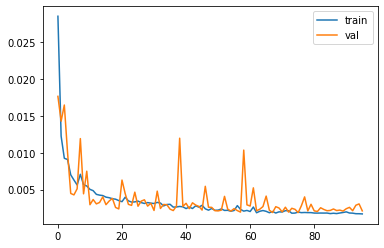

---Training time: 820.35162544 seconds ---


In [ ]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Reference_p5270/Data-driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [ ]:
# # Save the model
# print(model.summary())
# plot_model(model, show_shapes=True)
# model.save('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/Reference_p5270/Reference/DD_Transfer_model_70_10_20.h5')

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing 
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.97790, Train (V) - 0.81441
R2 scores: Validation (SS) - 0.97625, Validation (V) - 0.91285
R2 scores: Testing (SS) - 0.94059, Testing (V) - 0.84617
RMSE scores: Train (SS) - 0.02495, Train (V) - 0.04164
RMSE scores: Validation (SS) - 0.02949, Validation (V) - 0.03573
RMSE scores: Testing (SS) - 0.04571, Testing (V) - 0.04612


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

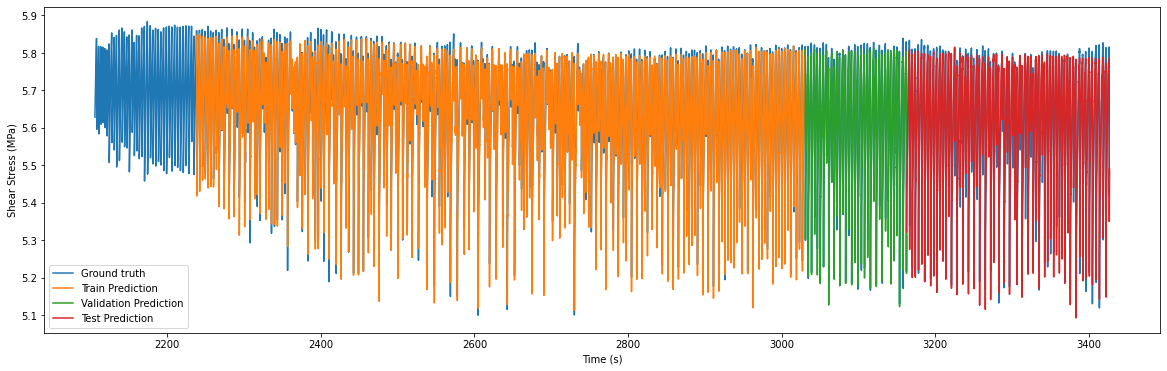

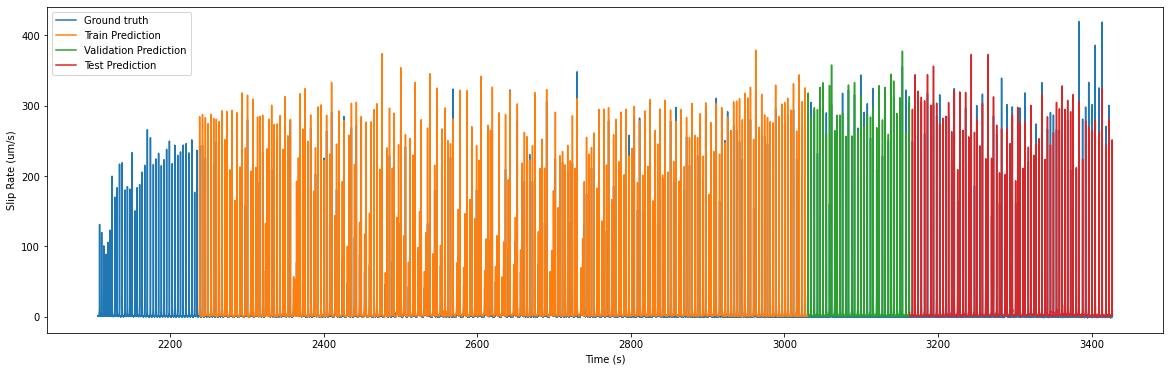

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[13210:92469] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

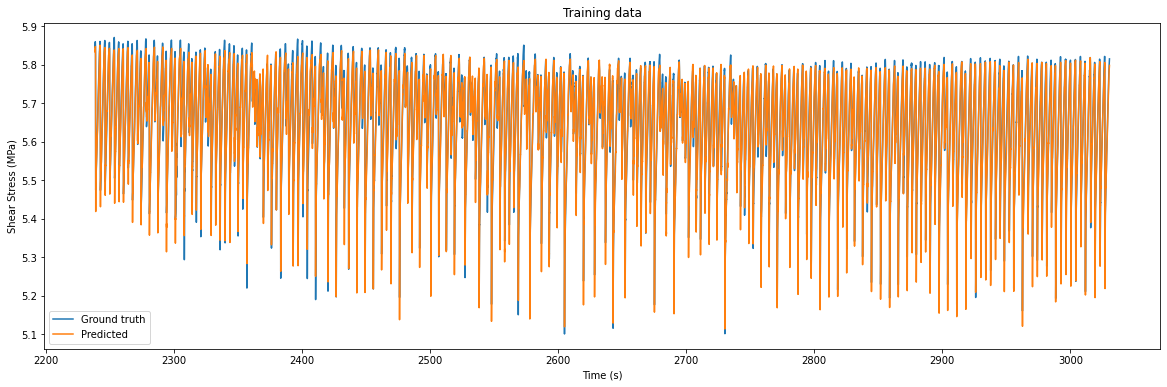

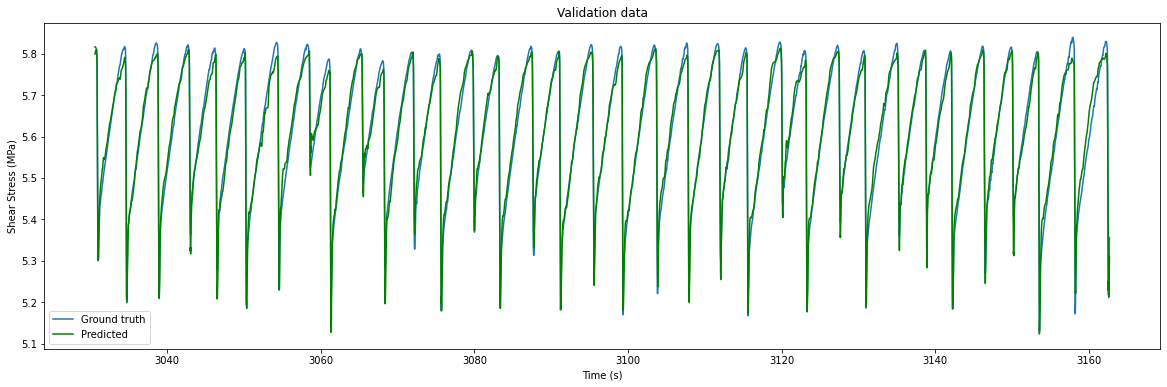

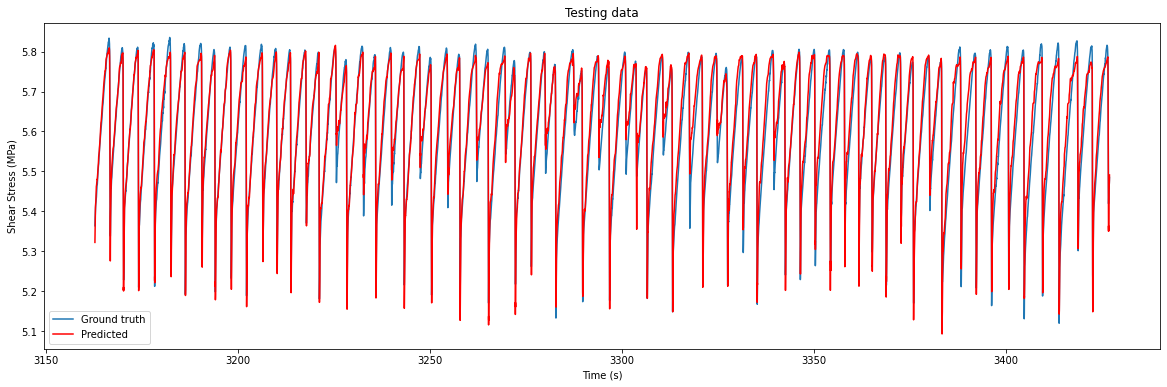

In [ ]:
# Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

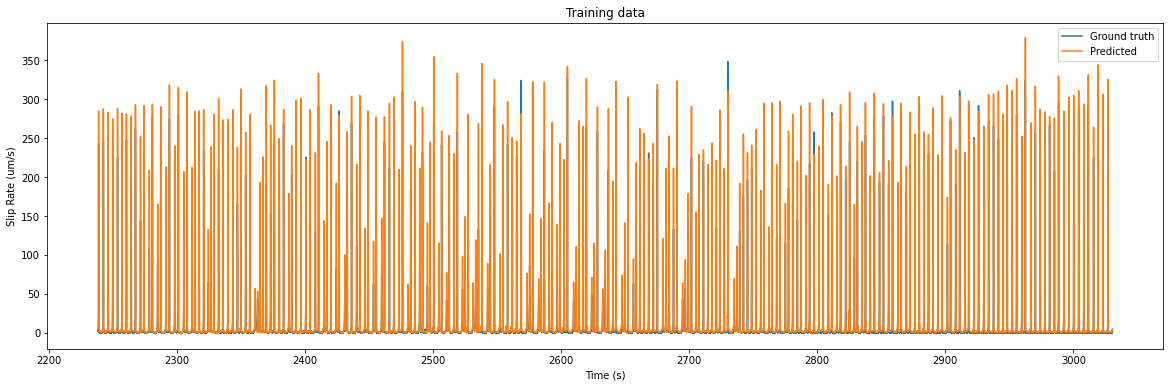

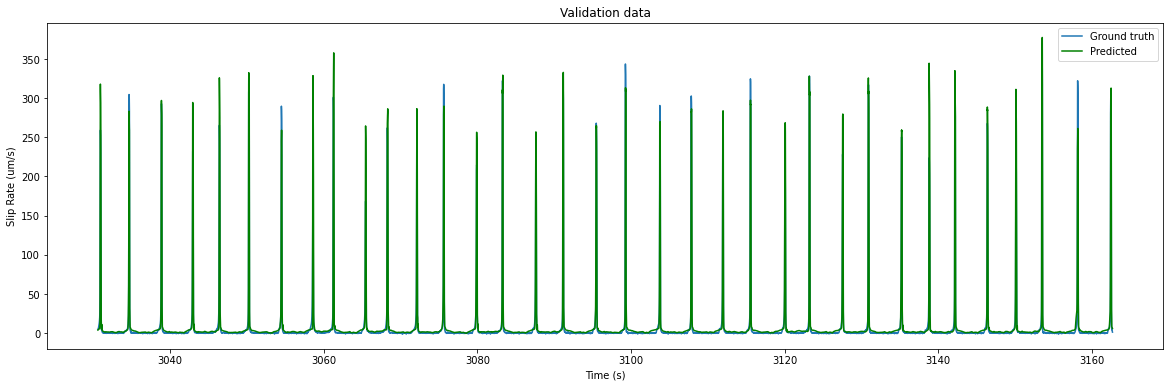

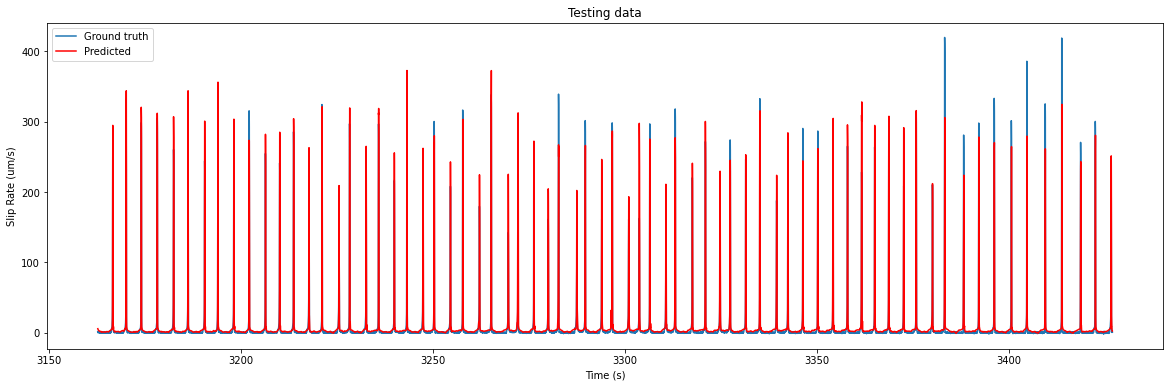

In [ ]:
# Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')

In [ ]:
# # Extract Data

# # Time 
# savetxt('Whole_time.csv', ttime, delimiter=',')
# savetxt('traintime.csv', traintime, delimiter=',')
# savetxt('valtime.csv', valtime, delimiter=',')
# savetxt('testtime.csv', testtime, delimiter=',')

# # SS
# savetxt('Y_train_SS.csv', Y_train_SS, delimiter=',')
# savetxt('Y_val_SS.csv', Y_val_SS, delimiter=',')
# savetxt('y_test_SS.csv', y_test_SS, delimiter=',')
# savetxt('y_predtrain_SS.csv', y_predtrain_SS, delimiter=',')
# savetxt('y_predval_SS.csv', y_predval_SS, delimiter=',')
# savetxt('y_predtest_SS.csv', y_predtest_SS, delimiter=',')

# # V
# savetxt('Y_train_V.csv', Y_train_V, delimiter=',')
# savetxt('Y_val_V.csv', Y_val_V, delimiter=',')
# savetxt('y_test_V.csv', y_test_V, delimiter=',')
# savetxt('y_predtrain_V.csv', y_predtrain_V, delimiter=',')
# savetxt('y_predval_V.csv', y_predval_V, delimiter=',')
# savetxt('y_predtest_V.csv', y_predtest_V, delimiter=',')

# # Download
# files.download('Whole_time.csv')
# files.download('traintime.csv')
# files.download('valtime.csv')
# files.download('testtime.csv')

# files.download('Y_train_SS.csv')
# files.download('Y_val_SS.csv')
# files.download('y_test_SS.csv')
# files.download('y_predtrain_SS.csv')
# files.download('y_predval_SS.csv')
# files.download('y_predtest_SS.csv')

# files.download('Y_train_V.csv')
# files.download('Y_val_V.csv')
# files.download('y_test_V.csv')
# files.download('y_predtrain_V.csv')
# files.download('y_predval_V.csv')
# files.download('y_predtest_V.csv')